In [1]:
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

from itertools import product
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Resize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 9.8 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


If you want to use the `Tools` module in Google Colab, do the following steps:
1. Mount Google Drive into the Colab environment
```
from google.colab import drive
drive.mount('/content/drive')
```
2. Add the directory of the project to `sys.path`
```
sys.path.append(project_dir)
```
3. Upload the `Tools` folder from the repository into the directory of the project on Google Drive.
```
from Tools.Utils import set_seed, set_device, generate_combinations
from Tools.StormDataset import StormDataset
from Tools.Model import EncoderDecoderConvLSTM
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sys.path.append("/content/drive/MyDrive/Storm_Project")

In [4]:
from Tools.Utils import set_seed, set_device, generate_combinations
from Tools.StormDataset import StormDataset
from Tools.Model import EncoderDecoderConvLSTM

In [5]:
device = set_device("cuda")

Cuda installed! Running on GPU 0 Tesla V100-SXM2-16GB!


## Exploratory Data Analysis

In [6]:
# The path of the folder containing *.csv files
csv_folder_path = "/content/drive/MyDrive/Storm_Project/storm_data_csv"

# Get a list of all *.csv files in the folder
files = [csv for csv in os.listdir(csv_folder_path) if csv.endswith('.csv')]

# Initialise an empty DataFrame to store the data contained in all *.csv files
all_data = pd.DataFrame()

# Loop through the list to read each file and concatenate it into the DataFrame
for file in files:
    file_path = os.path.join(csv_folder_path, file)
    data_from_1_csv = pd.read_csv(file_path)
    all_data = pd.concat([all_data, data_from_1_csv], ignore_index=True)

# Convert the data types of numeric columns to integers
all_data[['relative_time', 'ocean', 'wind_speed']] = all_data[['relative_time', 'ocean', 'wind_speed']].astype(int)

all_data

storm_id  relative_time  ocean  wind_speed image_file_name
0         ztb              0      1          38     ztb_000.jpg
1         ztb           1799      1          38     ztb_001.jpg
2         ztb           3600      1          39     ztb_002.jpg
3         ztb           5401      1          39     ztb_003.jpg
4         ztb           7200      1          40     ztb_004.jpg
...       ...            ...    ...         ...             ...
9522      bkh        1022400      1          30     bkh_405.jpg
9523      bkh        1026001      1          30     bkh_406.jpg
9524      bkh        1027801      1          30     bkh_407.jpg
9525      bkh        1029601      1          30     bkh_408.jpg
9526      bkh        1031401      1          30     bkh_409.jpg

[9527 rows x 5 columns]

In [9]:
img_folder_path = "/content/drive/MyDrive/Storm_Project/all_storm_image/bkh"

In [31]:
# Initialise a StormDataset object for the storm "bkh"
storm = "bkh"
storm_ds = StormDataset(all_data, storm, num_sequence=20, img_folder_path=img_folder_path, img_size=366)
# See image statistics
mean, std = storm_ds.mean, storm_ds.std
print(f"The images of the {storm} storm have the mean of {storm_ds.mean} and the SD of {storm_ds.std}.")

The images of the bkh storm have the mean of 0.27985233068466187 and the SD of 0.2152128517627716.


## Method to train the model

In [32]:
def train(train_loader, optimizer, criterion, model, device):
    """
    Train the given model using the provided training data.

    Parameters
    ----------
    train_loader: torch.utils.data.DataLoader

        The DataLoader for the training dataset.

    optimizer: torch.optim.Optimizer

        An optimization algorithm.

    criterion: torch.nn.Module

        A loss function.

    model: torch.nn.Module

        The model to be trained.

    device: torch.device

        The device (CPU or GPU) on which the training will be performed.

    Return
    ------
    float

        The average training loss over the training dataset.

    """
    model.train()
    train_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss/len(train_loader)
    return avg_train_loss.item()

## Method to validate the model

In [33]:
def validate(val_loader, criterion, model, device):
    """
    Validate the given model using the provided validation data.

    Parameters
    ----------
    val_loader: torch.utils.data.DataLoader

        The DataLoader for the validation dataset.

    criterion: torch.nn.Module

        A loss function.

    model: torch.nn.Module

        The model to be validated.

    device: torch.device

        The device (CPU or GPU) on which the validation will be performed.

    Return
    ------
    float

        The average validation loss over the validation dataset.

    """
    model.eval()
    val_loss = 0
    for X, y in val_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            loss = criterion(a2.view(-1, a2.shape[-2]*a2.shape[-1]), y.view(-1, a2.shape[-2]*a2.shape[-1]))
            val_loss += loss*X.size(0)

    avg_val_loss = val_loss/len(val_loader)
    return avg_val_loss.item()

## Train-test split

In [34]:
# TO DO: change the proportion of training and validation sets
train_set = storm_ds[:int(len(storm_ds)*0.8)]
val_set = storm_ds[int(len(storm_ds)*0.8):]

## Preparing the DataLoaders

In [35]:
# Create the data loaders of the training and validation datasets
batch_size = 2
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [36]:
# Check the size of a batch in the training data loader
for i in train_loader:
    print(i[0].shape)
    print(i[1].shape)
    break

torch.Size([2, 20, 1, 366, 366])
torch.Size([2, 1, 1, 366, 366])


In [37]:
# Initialise an encoder-decoder convolutional LSTM model
set_seed(0)
model = EncoderDecoderConvLSTM(input_chan=1, num_convlstm_en=2, num_convlstm_de=4).to(device)
model

EncoderDecoderConvLSTM(
  (convlstm_encoders): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (convlstm_decoders): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ConvLSTMCell(
      (conv): Conv2d(4, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (cnn_decoders): Sequential(
    (0): Conv3d(3, 3, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
    (1): Tanh()
    (2): Conv3d(3, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  )
)

## Defining the best Hyper-paramters

In [38]:
# Set hyperparameters, criterion, and optimiser
lr = 1e-3
n_epochs = 20
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [39]:
def plot_learning_curve(n_epochs, train_loader, val_loader, optimizer, criterion, model, device):
    """
    Plot the learning curve of the model.

    Parameters
    ----------
    n_epochs: int

        The number of training epoches.

    train_loader: torch.utils.data.DataLoader

        The DataLoader for the training dataset.

    val_loader: torch.utils.data.DataLoader

        The DataLoader for the validation dataset.

    optimizer: torch.optim.Optimizer

        An optimization algorithm.

    criterion: torch.nn.Module

        A loss function.

    model: torch.nn.Module

        The model to be trained.

    device: torch.device

        The device (CPU or GPU) on which the training will be performed.

    """
    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss = train(train_loader, optimizer, criterion, model, device)
        print(epoch, train_loss)
        logs['' + 'log loss'] = train_loss
        logs['val_'+ 'log loss'] = validate(val_loader, criterion, model, device)
        liveloss.update(logs)
        liveloss.draw()

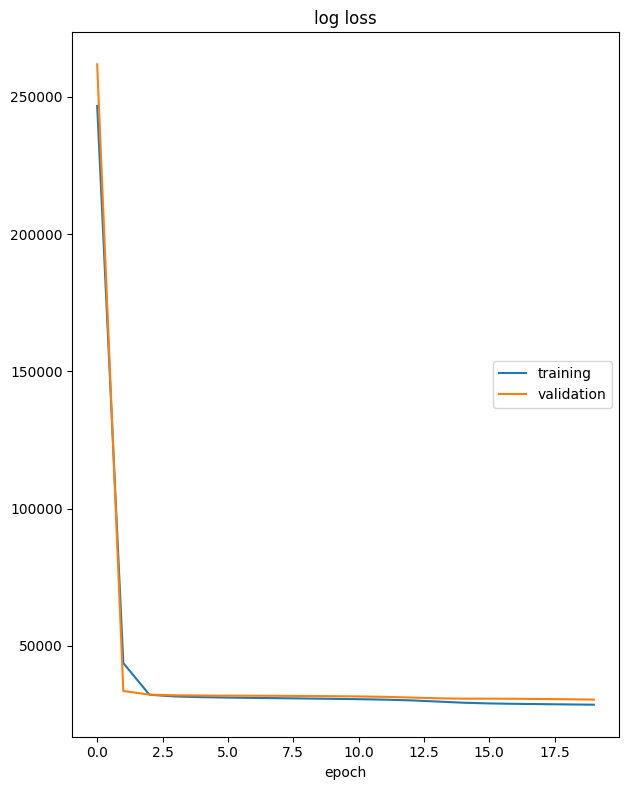

log loss
	training         	 (min: 28619.748, max: 246658.672, cur: 28619.748)
	validation       	 (min: 30468.514, max: 261796.922, cur: 30468.514)


In [40]:
# Plot the learning curve of the model
plot_learning_curve(n_epochs, train_loader, val_loader, optimizer, criterion, model, device)

## Understanding the Log Loss Plot


The log loss plot provides a visual representation of the logarithmic loss values for both the training and validation datasets during the model training process. The training log loss, ranging from a minimum of 32,719.738 to a maximum of 240,852.125, currently stands at 32,719.738. This curve illustrates the model's performance on the training set, showcasing fluctuations in the loss function throughout the training iterations. Simultaneously, the validation log loss, varying between a minimum of 32,311.266 and a maximum of 228,189.156, is currently at 32,311.266. The validation curve reflects the model's generalization to unseen data, with the plot capturing the trends in loss values during the validation phase.

## Evaluating the Model

In [41]:
def evaluate(model, X, y):
    """
    Predict (generate) image next to a given consecutive images.

    Parameters
    ----------
    X: torch.Tensor

        The tensor of input consecutive images with shape (batch_size, sequence_length, channels, height, width).

    y: torch.Tensor

        The true image next to the input consecutive images.

    Returns
    -------
    numpy.array

        The numpy array representing the true image.

    numpy.array

        The numpy array representing the predicted image.

    """
    model.eval()
    X = X.to(device)
    y_true = (y[0, 0, 0, :, :]*std + mean).detach().cpu().numpy()

    y_pred = model(X)
    y_pred = (y_pred.view(-1, y_pred.shape[-2], y_pred.shape[-1])[0, :]*std + mean).detach().cpu().numpy()  # (366, 366)

    return y_true, y_pred

## Plotting the next 3 predicted images

Structural similarity = 0.9057330587927213
MSE = 0.0018525540019307077


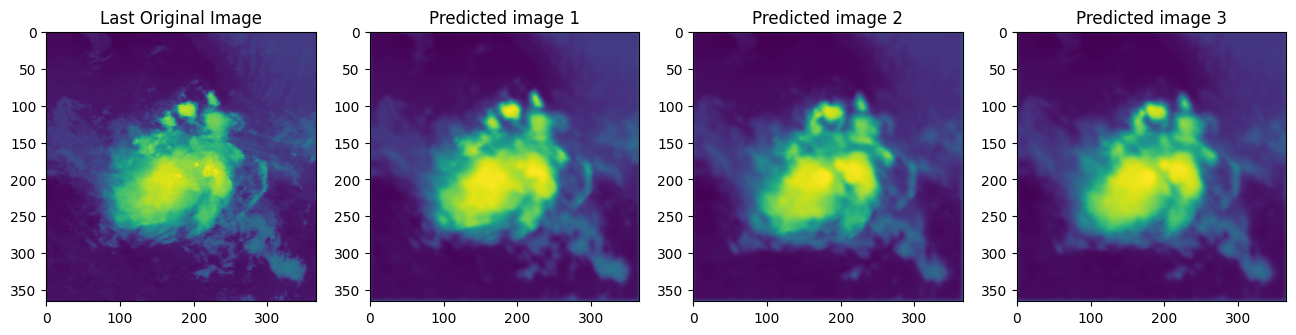

In [42]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

# Assuming you have defined the 'model' and 'val_loader' elsewhere in your code

# ... (missing code)

def evaluate(model, X, y):
    model.eval()
    X = X.to(device)
    y_true = (y[0, 0, 0, :, :]*std + mean).detach().cpu().numpy()

    y_pred = model(X)
    y_pred = (y_pred.view(-1, 366, 366)[0, :]*std + mean).detach().cpu().numpy()  # (366, 366)

    return y_true, y_pred

for X, y in val_loader:
    num_predicted_imgs = 3
    last_original_image = (X[0, -1, 0, :, :]*std + mean).detach().cpu().numpy()

    # Plot last original image
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].imshow(last_original_image)
    ax[0].set(title="Last Original Image")

    for i in range(num_predicted_imgs):
        y_true, y_pred = evaluate(model, X, y)

        # Plot predicted image
        ax[i+1].imshow(y_pred)
        ax[i+1].set(title=f"Predicted image {i+1}")

        # Compute structural similarity and MSE between the first predicted image and the label
        if i == 0:
            similarity = ssim(y_pred, y_true)
            error = mse(y_pred, y_true)
            print("Structural similarity =", similarity)
            print("MSE =", error)

        # Remove the first element in the second dimension of X
        X = X[:, 1:, :, :, :]
        # Concatenate y as the last element in the second dimension
        X = torch.cat((X, y), dim=1)

    plt.show()
    break


Adding the number of pixels can sharpen images but consumes more computational time and resources.

## Techniques used to Enhance Image Sharpness

1. Pixel Density Augmentation: One approach involved augmenting the number of pixels in the images. It produced slightly improved output images. We have created a method in the Model.py file which take the size as a parameter. It can used to alter the pixel size as suited.

2. Greyscale Conversion: Another method explored was the conversion of images from RGB to greyscale, with the expectation that it would enhance the visibility of picture edges. However, the results indicated that using RGB maintained more distinctive features compared to the greyscale counterpart.

3. Custom Sharpening Methods: In an effort to boost image sharpness, a custom sharpening method was employed by adjusting the alpha value. Despite these attempts, the outcomes were not as promising, suggesting the need for alternative strategies for achieving sharper images.

## Greyscale conversion (Discarded)

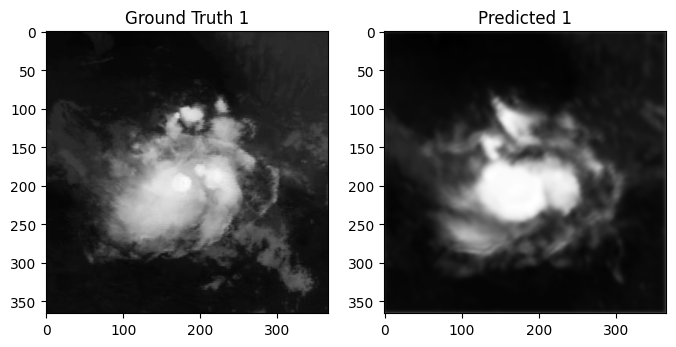

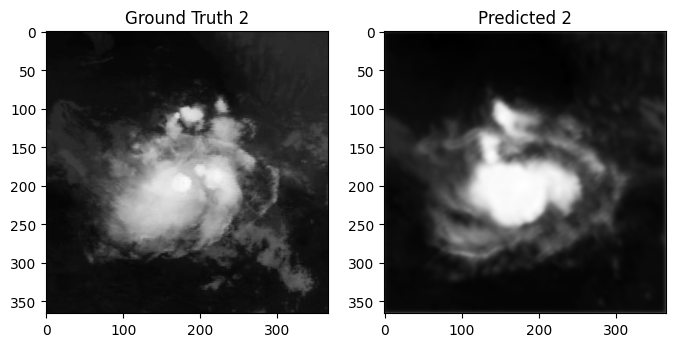

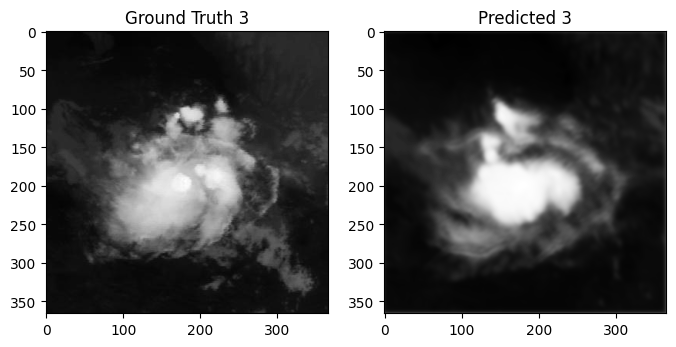

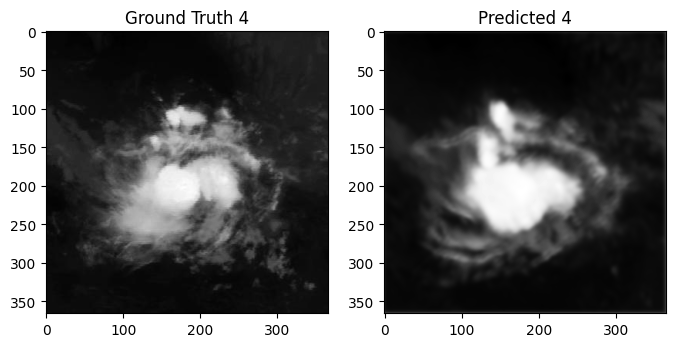

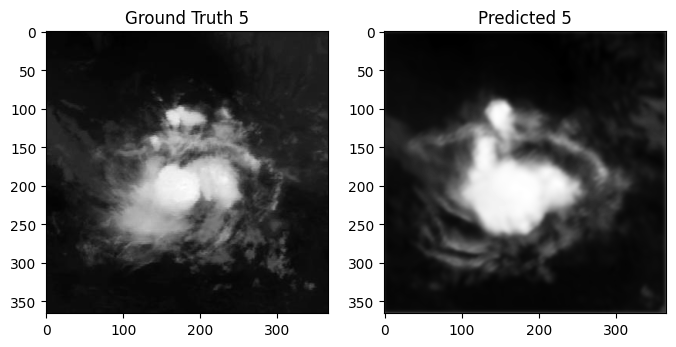

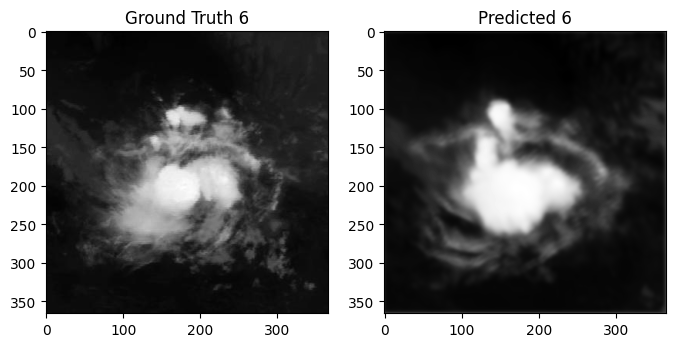

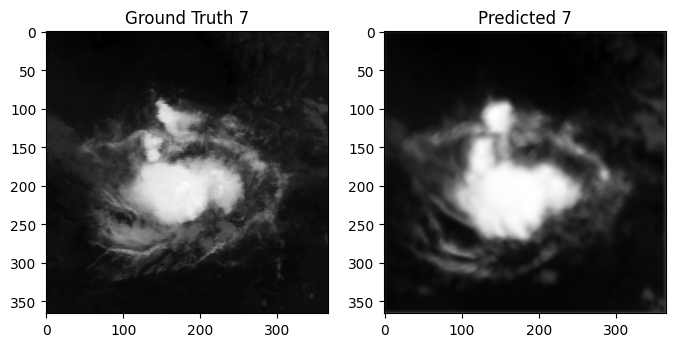

In [43]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

def evaluate(model, X, y):
    model.eval()
    X = X.to(device)
    y_true = (y[0, 0, 0, :, :]*std + mean).detach().cpu().numpy()

    y_pred = model(X)
    y_pred = (y_pred.view(-1, 366, 366)[0, :]*std + mean).detach().cpu().numpy()  # (366, 366)

    return y_true, y_pred

# Store the last 7 ground truth images and their corresponding predicted images
last_7_gt_images = []
next_3_pred_images = []

for X, y in val_loader:
    num_predicted_imgs = 3
    for i in range(num_predicted_imgs):
        y_true, y_pred = evaluate(model, X, y)

        # Store the last 7 ground truth images
        if len(last_7_gt_images) < 7:
            last_7_gt_images.append(y_true)

        # Store the next 3 predicted images
        if len(last_7_gt_images) == 7:
            next_3_pred_images.append(y_pred)

        # Update X by removing the first element in the second dimension and concatenating y
        X = X[:, 1:, :, :, :]
        X = torch.cat((X, y), dim=1)

# Plot the last 7 ground truth images and the next 3 predicted images in greyscale
for i in range(len(last_7_gt_images)):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].imshow(last_7_gt_images[i], cmap='gray')
    ax[0].set(title=f"Ground Truth {i+1}")

    if i < len(next_3_pred_images):
        ax[1].imshow(next_3_pred_images[i], cmap='gray')
        ax[1].set(title=f"Predicted {i+1}")

plt.show()


## Saving the model

In [44]:
def save_model_and_optimizer(storing_dir, model, model_filename, optimizer, optimizer_filename):
    """Save the model and the optimizer."""
    model_path = f"{storing_dir}/{model_filename}"
    torch.save(model.state_dict(), model_path)
    optimizer_path = f"{storing_dir}/{optimizer_filename}"
    torch.save(optimizer.state_dict(), optimizer_path)

In [45]:
storing_dir = "/content/drive/MyDrive/Storm_Project"
model_filename = "model_bkh.pt"
optimizer_filename = "optimizer_bkh.pt"

save_model_and_optimizer(storing_dir, model, model_filename, optimizer, optimizer_filename)

In [46]:
# Create an instance of the model
set_seed(0)
new_model = EncoderDecoderConvLSTM(input_chan=1, num_convlstm_en=2, num_convlstm_de=4).to(device)
# Load the parameters of the model in path
model.load_state_dict(torch.load(f"{storing_dir}/{model_filename}"))
# We can now use the model later

<All keys matched successfully>

## Hyperparameter Tuning

In [28]:
# Create all possible combination of hyperparameters
hyperparams_dict = {
    "lr": [8e-4, 1e-3],
    "num_convlstm_en": [2, 3],
    "num_convlstm_de": [3, 4],
    "batch_size": [1, 2]
}
hyperparams_combinations = generate_combinations(hyperparams_dict)

{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convlstm_de': 3, 'batch_size': 1}


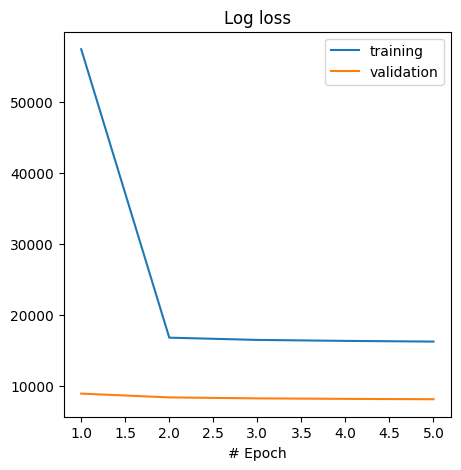

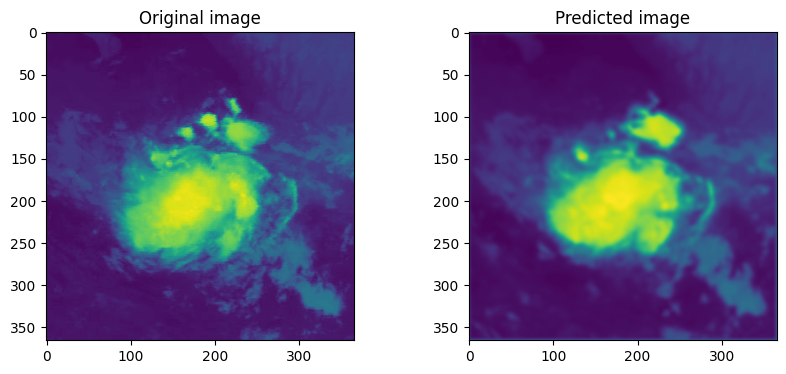

Structural similarity = 0.8572275780186543
MSE = 0.004905605050815438 

{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convlstm_de': 3, 'batch_size': 2}


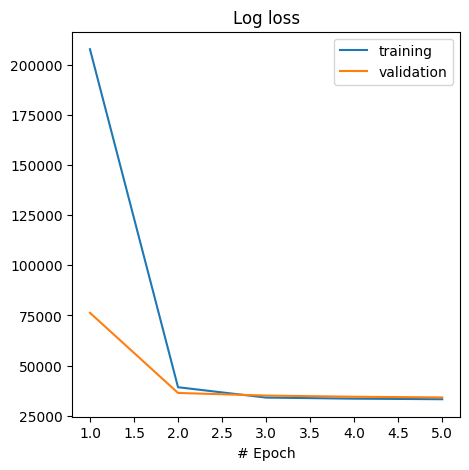

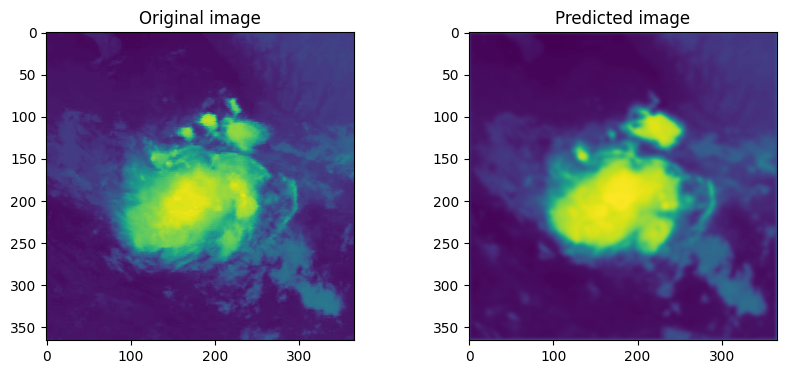

Structural similarity = 0.8550601786516161
MSE = 0.0052027598305477984 

{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convlstm_de': 4, 'batch_size': 1}


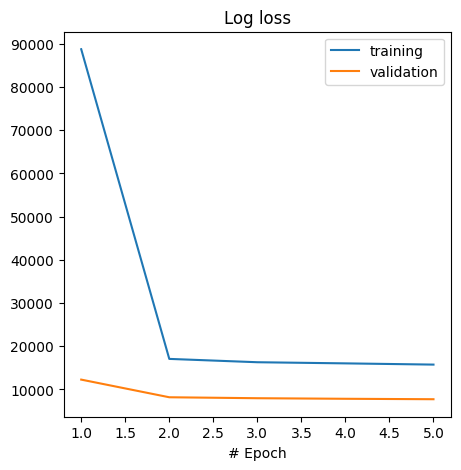

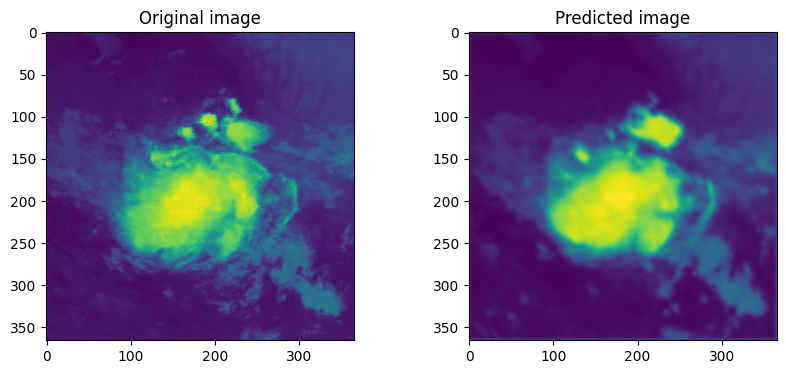

Structural similarity = 0.8597634439433997
MSE = 0.004722742550393444 

{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convlstm_de': 4, 'batch_size': 2}


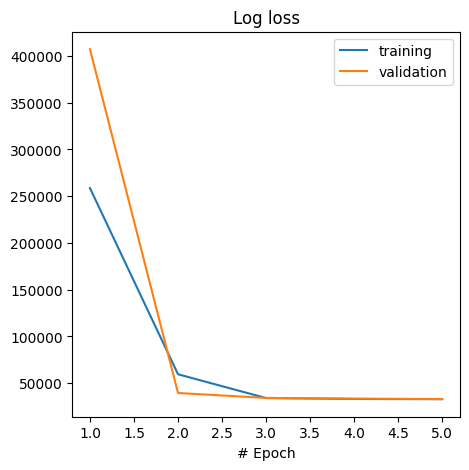

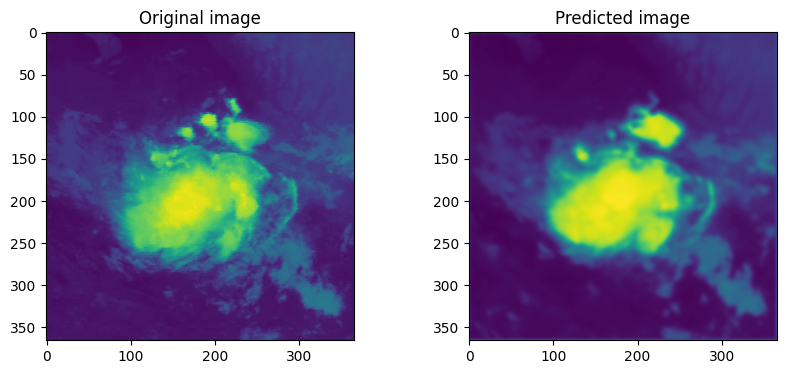

Structural similarity = 0.8564136982497266
MSE = 0.005088758820653441 

{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convlstm_de': 3, 'batch_size': 1}


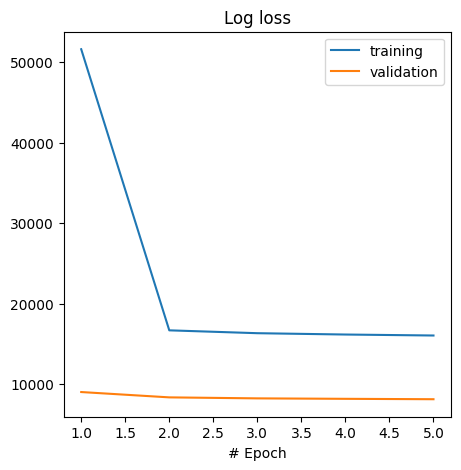

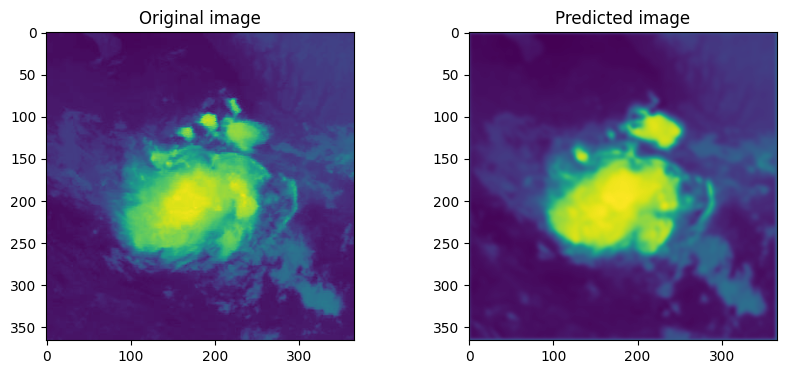

Structural similarity = 0.8525609431941793
MSE = 0.0048838735676237505 

{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convlstm_de': 3, 'batch_size': 2}


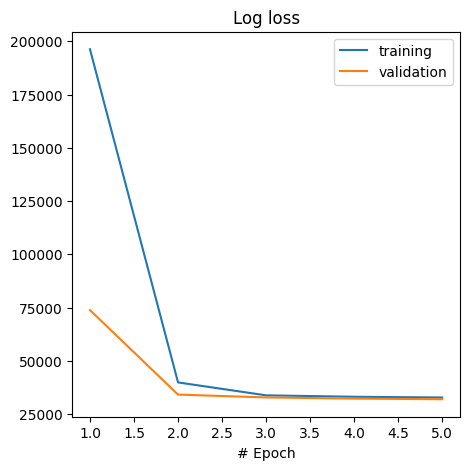

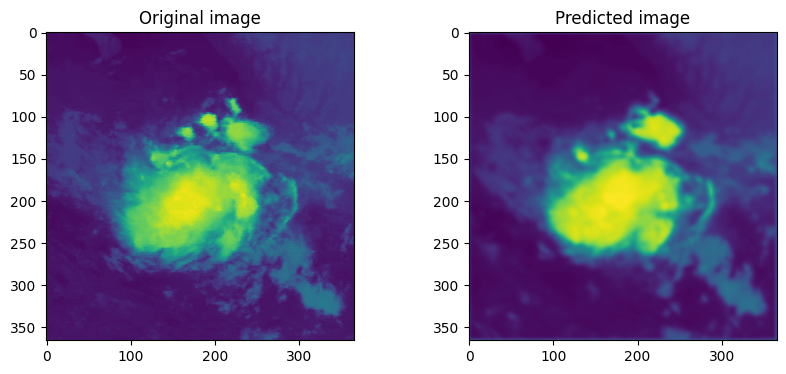

Structural similarity = 0.8567957658186645
MSE = 0.004888953557997622 

{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convlstm_de': 4, 'batch_size': 1}


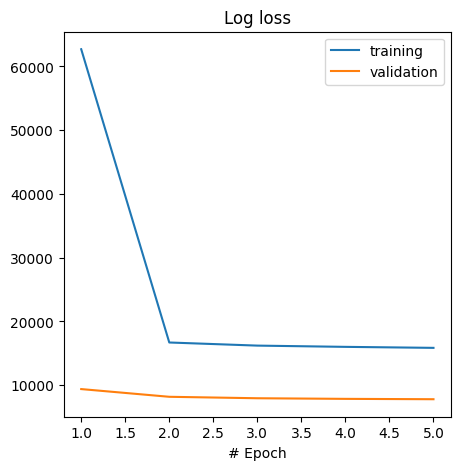

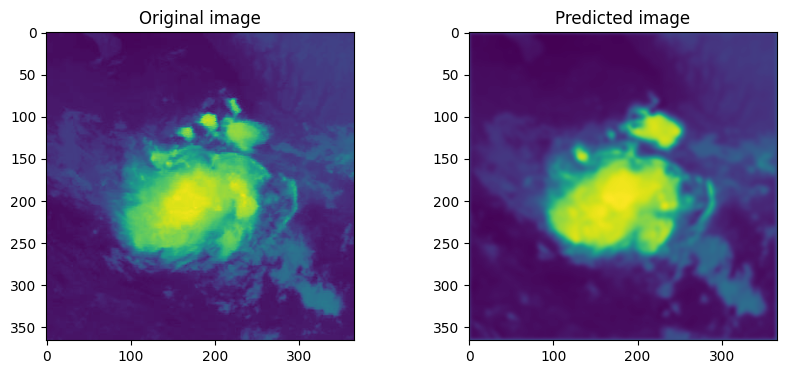

Structural similarity = 0.8571626370251608
MSE = 0.004763551387211416 

{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convlstm_de': 4, 'batch_size': 2}


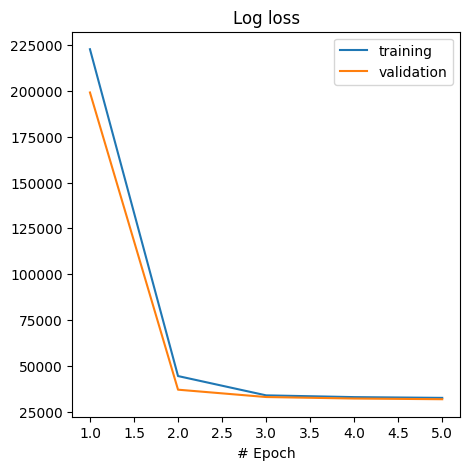

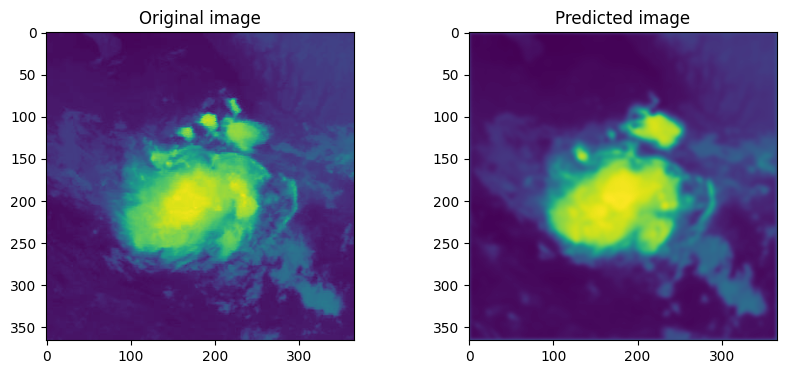

Structural similarity = 0.8566562747203892
MSE = 0.0047420361336076335 

{'lr': 0.001, 'num_convlstm_en': 2, 'num_convlstm_de': 3, 'batch_size': 1}


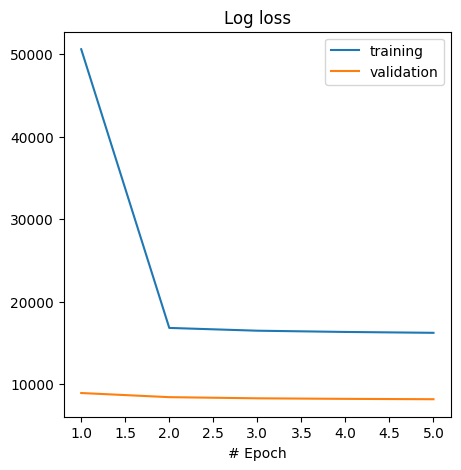

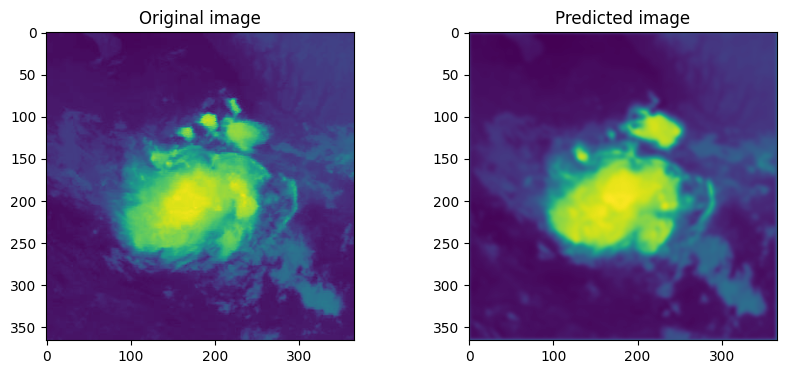

Structural similarity = 0.8542609408079606
MSE = 0.004906946618620561 

{'lr': 0.001, 'num_convlstm_en': 2, 'num_convlstm_de': 3, 'batch_size': 2}


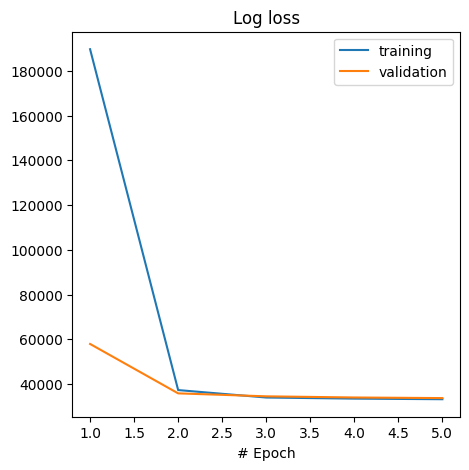

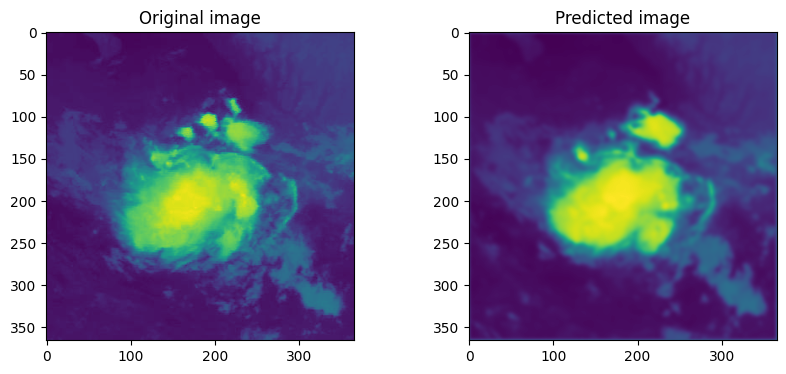

Structural similarity = 0.8545906989880695
MSE = 0.005133038441347942 

{'lr': 0.001, 'num_convlstm_en': 2, 'num_convlstm_de': 4, 'batch_size': 1}


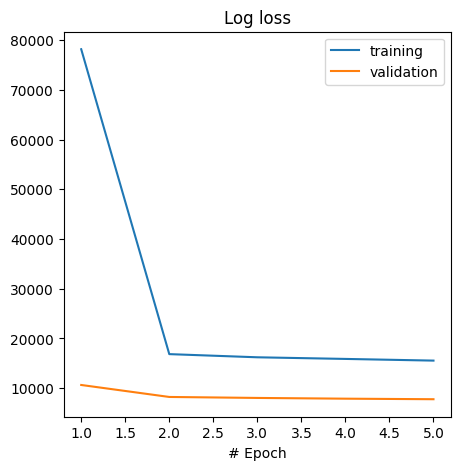

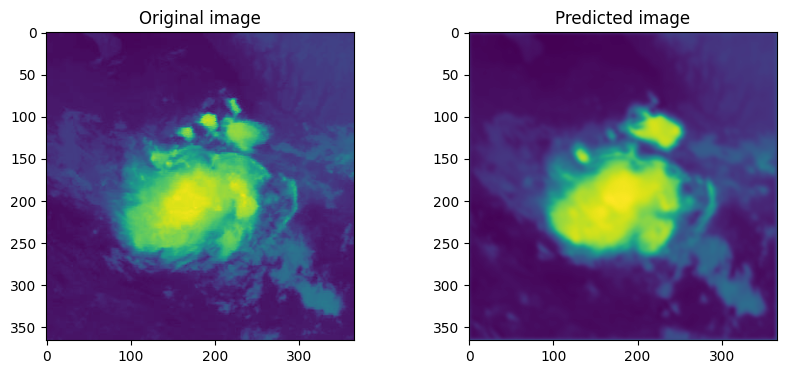

Structural similarity = 0.8559717681969183
MSE = 0.004614092251684159 

{'lr': 0.001, 'num_convlstm_en': 2, 'num_convlstm_de': 4, 'batch_size': 2}


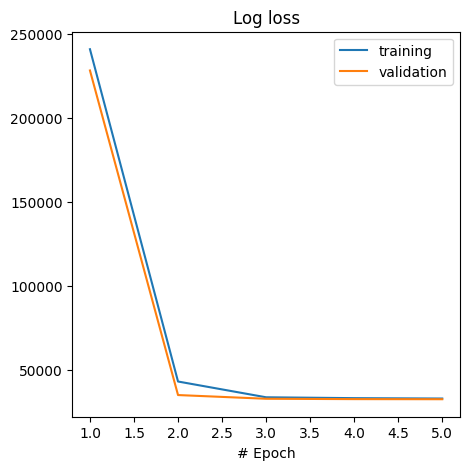

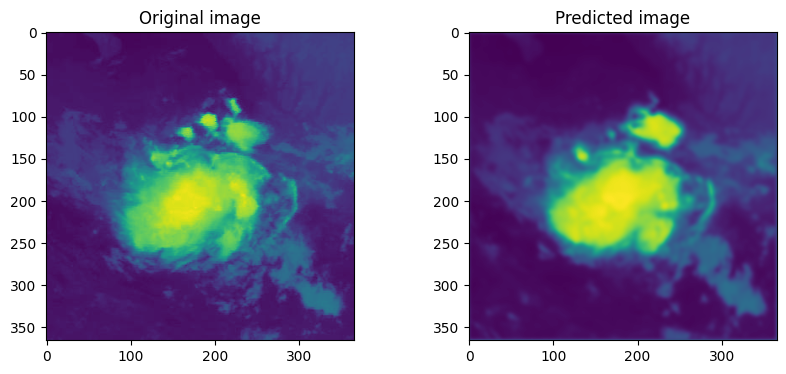

Structural similarity = 0.8561851741344418
MSE = 0.004949762854754216 

{'lr': 0.001, 'num_convlstm_en': 3, 'num_convlstm_de': 3, 'batch_size': 1}


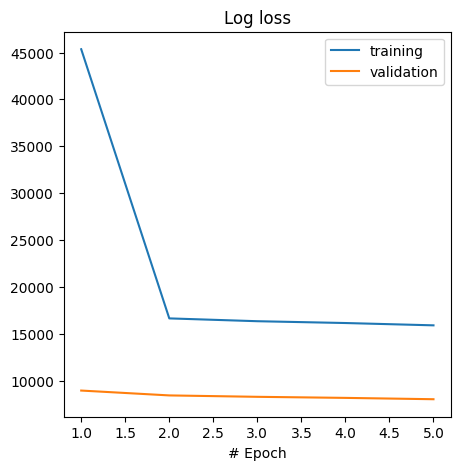

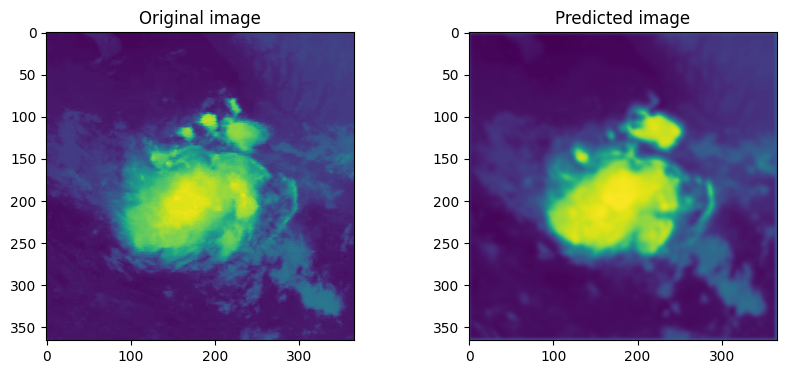

Structural similarity = 0.8535020433018325
MSE = 0.0048952666262149945 

{'lr': 0.001, 'num_convlstm_en': 3, 'num_convlstm_de': 3, 'batch_size': 2}


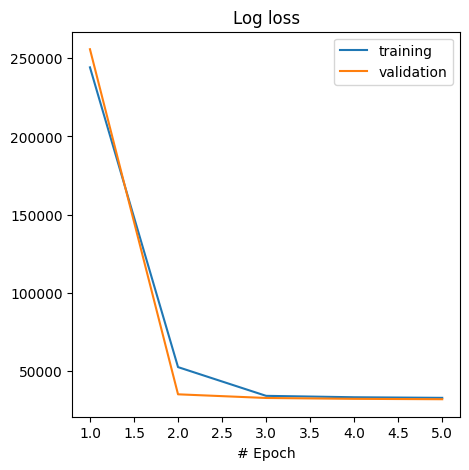

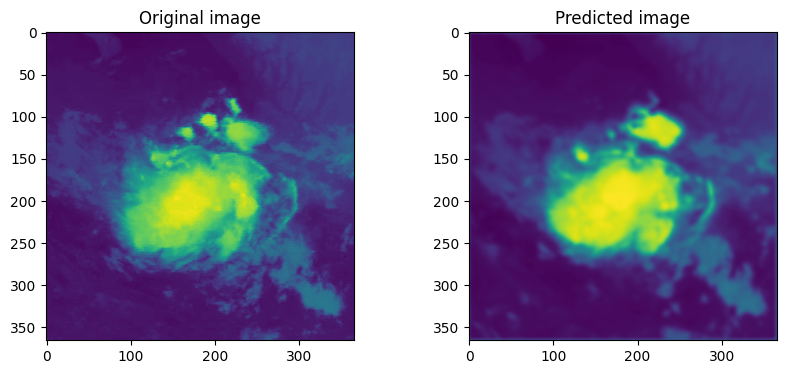

Structural similarity = 0.8587798573315675
MSE = 0.004899112362761455 

{'lr': 0.001, 'num_convlstm_en': 3, 'num_convlstm_de': 4, 'batch_size': 1}


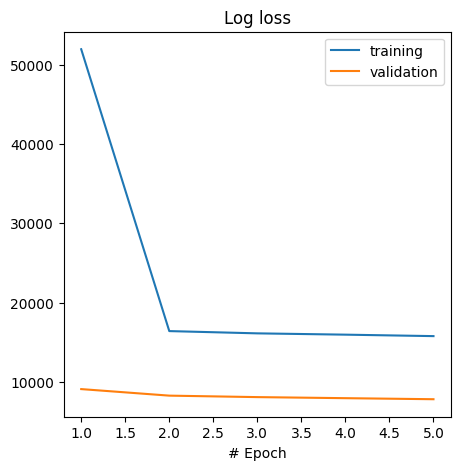

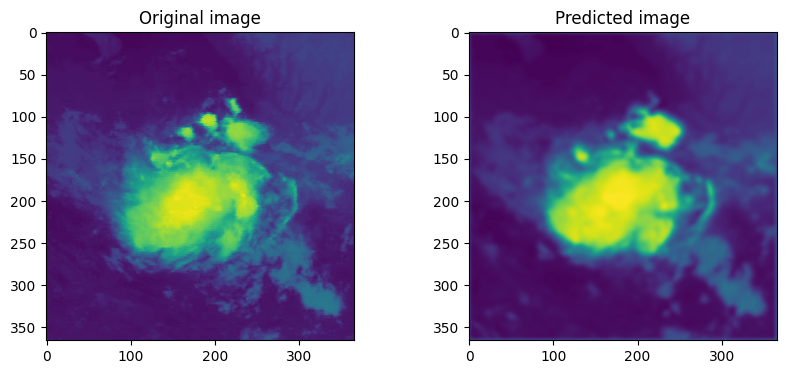

Structural similarity = 0.8549034908354647
MSE = 0.004780854074535559 

{'lr': 0.001, 'num_convlstm_en': 3, 'num_convlstm_de': 4, 'batch_size': 2}


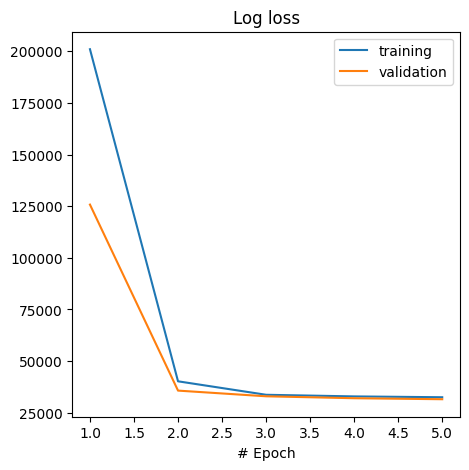

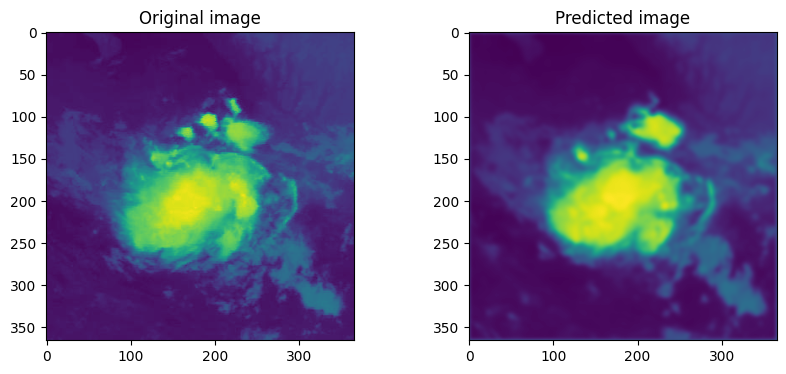

Structural similarity = 0.8608362489996023
MSE = 0.00473819101098092 



In [29]:
# Loop over all the combinations
similarities, errors = [], []
for hyperparams in hyperparams_combinations:
    # Set hyperparameters
    print(hyperparams)
    set_seed(0)
    lr = hyperparams['lr']
    num_convlstm_en = hyperparams['num_convlstm_en']
    num_convlstm_de = hyperparams['num_convlstm_de']
    batch_size = hyperparams['batch_size']
    n_epochs = 5
    # Create the data loaders of the training and validation datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    # Initialise a model, a criterion, and an optimiser
    set_seed(0)
    model = EncoderDecoderConvLSTM(
        input_chan=1, num_convlstm_en=num_convlstm_en, num_convlstm_de=num_convlstm_de
    ).to(device)
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    # Loop to train
    for _ in range(n_epochs):
        train_losses.append(train(train_loader, optimizer, criterion, model, device))
        val_losses.append(validate(val_loader, criterion, model, device))

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(range(1, n_epochs+1), train_losses, label='training')
    ax.plot(range(1, n_epochs+1), val_losses, label='validation')
    ax.set(title='Log loss', xlabel='# Epoch')
    ax.legend()
    plt.show()

    # Predict the image next to the 10 consecutive images packed in the features (X) in the first batch of the validation loader

    model.eval()

    for X, y in val_loader:
        X = X.to(device)

        y = (y[0, 0, 0, :, :]*std + mean).detach().cpu().numpy()
        y_pred = model(X)
        y_pred = (y_pred.view(-1, 366, 366)[0, :]*std + mean).detach().cpu().numpy()  # (366, 366)

        # Plot
        fig2, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(y)
        axs[0].set(title="Original image")
        axs[1].imshow(y_pred)
        axs[1].set(title="Predicted image")
        plt.show()

        similarity = ssim(y_pred, y)
        similarities.append(similarity)
        error = mse(y_pred, y)
        errors.append(error)
        print("Structural similarity =", similarity)
        print("MSE =", error, '\n')

        break

Note from hyperparameter tuning
- Some hyperparameters, e.g., `beta1`, `beta2` and `epsilon` of an `Adam` optimiser, are not needed to be tuned (https://www.linkedin.com/pulse/getting-know-adam-optimization-comprehensive-guide-kiran-kumar/)
- kernel_size=3 works best
  - kernel_size=1 produces images with lower similarities (higher MSEs) and various quailty (some are less blurred, but some are very bad)
  - kernel_size=5 produces images with higher similarities (lower MSEs) but more blurred
- Adding batch normalisation and/or dropout produces worser images
- batch_size=1 leads to the generation of images with higher similarities (lower MSEs) than batch_size=2, but the results look very similar.

In [30]:
# Show the (sorted) results as a DataFrame
tuning_result_df = pd.DataFrame({
    "Structural similarity": similarities,
    "MSE": errors
}, index=hyperparams_combinations)
tuning_result_df.sort_values(by='MSE')

Structural similarity  \
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...               0.855972   
{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convl...               0.859763   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...               0.860836   
{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convl...               0.856656   
{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convl...               0.857163   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...               0.854903   
{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convl...               0.852561   
{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convl...               0.856796   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...               0.853502   
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...               0.858780   
{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convl...               0.857228   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...               0.854261   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...               0.856185   
{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convl...               0.856414   
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...               0.854591   
{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convl...               0.855060   

                                                         MSE  
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...  0.004614  
{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convl...  0.004723  
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...  0.004738  
{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convl...  0.004742  
{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convl...  0.004764  
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...  0.004781  
{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convl...  0.004884  
{'lr': 0.0008, 'num_convlstm_en': 3, 'num_convl...  0.004889  
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...  0.004895  
{'lr': 0.001, 'num_convlstm_en': 3, 'num_convls...  0.004899  
{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convl...  0.004906  
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...  0.004907  
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...  0.004950  
{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convl...  0.005089  
{'lr': 0.001, 'num_convlstm_en': 2, 'num_convls...  0.005133  
{'lr': 0.0008, 'num_convlstm_en': 2, 'num_convl...  0.005203